In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #only show errors (hide INFO and WARNING)

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

random.seed(1234)   
np.random.seed(1234)


In [2]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [3]:
def build_model(number_of_features, dense_layers_unit_array=[], learningRate=0.001,
                activation="relu", isBatchNormalized=False, dropOutRate=-1,
                startWithBatchNormalized=False,optimizer="Adam"):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of GPU/CPU: {}'.format(strategy.num_replicas_in_sync))
    
    print("num_of_dense_layers:",len(dense_layers_unit_array))
    
    for i, dense_layer_unit in enumerate(dense_layers_unit_array):       
        print("dense_layer["+str(i)+"]; unit:"+str(dense_layer_unit))        
       
    print("learningRate:",learningRate)
    print("isBatchNormalized:",isBatchNormalized,"; dropOutRate:",dropOutRate)
    print("startWithBatchNormalized:",startWithBatchNormalized)
    print("optimizer:",optimizer,"; activation:",activation)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential() 
        
        if startWithBatchNormalized:
            model.add(BatchNormalization())
        
        # Add Dense layers
        for i, dense_layer_unit in enumerate(dense_layers_unit_array):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_unit,
                name='fc_'+str(i), 
                activation=activation))
            if isBatchNormalized:
                model.add(BatchNormalization())
            if dropOutRate > 0:
                model.add(Dropout(dropOutRate))

        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, number_of_features))

        if optimizer=="Adam":
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        elif optimizer=="SGD":
            opt = keras.optimizers.SGD(learning_rate=learningRate)
        else:
            opt = keras.optimizers.Adam(learning_rate=learningRate)    
        

        model.compile(optimizer=opt,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])    
    
    return model
    

In [4]:
def train_and_test_model(train_dataset, validate_dataset, x_train,
                         save_to, epoch = 2,
                         dense_layers_unit_array=[],
                         patience=10, epoch_denominator=10.,
                         isConstantLearningRate=False, learningRate=0.001,
                         activation="relu", isBatchNormalized=False,dropOutRate=0,
                         startWithBatchNormalized=False,optimizer="Adam"):
    
    print("epoch:",epoch, "; epoch_denominator:",epoch_denominator) 
    print("patience:",patience,"; isConstantLearningRate:", isConstantLearningRate) 
    
    model = build_model(x_train.shape[1],
                        dense_layers_unit_array=dense_layers_unit_array, learningRate=learningRate,
                        activation=activation, isBatchNormalized=isBatchNormalized, dropOutRate=dropOutRate,
                        startWithBatchNormalized=startWithBatchNormalized,optimizer=optimizer
                       )

    model.summary()
    tf.keras.utils.plot_model(model)  
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    if isConstantLearningRate:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
    else:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))

    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])

    history_data = pd.DataFrame(history.history)
    plot_loss_history(history_data)
    plot_accuracy_history(history_data)

    # test model
    test_results = model.evaluate(test_dataset)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    # show classification report
    y_predict = np.array(model.predict(test_dataset))
    y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
    print(classification_report(y_test, y_predict))
    
    print("Confusion matrix")
    print(confusion_matrix(y_test.values.argmax(axis=1), np.argmax(y_predict, axis=1)))


Load the test/validate/test dataset from files.
The sets are splitted and randomly shuffled by participants.

In [5]:
train_csv_dataset = pd.read_csv('csv/out_gameemo_train_dataset.csv',  sep=',')
validate_csv_dataset = pd.read_csv('csv/out_gameemo_validate_dataset.csv',  sep=',')
test_csv_dataset = pd.read_csv('csv/out_gameemo_test_dataset.csv',  sep=',')

print('Shape of data: ', train_csv_dataset.shape)

Shape of data:  (23405, 3739)


In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

train_init_df = train_csv_dataset.copy()
validate_init_df = validate_csv_dataset.copy()
test_init_df = test_csv_dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

train_init_df["Label"] = train_init_df["Label"].map(label_map)
validate_init_df["Label"] = validate_init_df["Label"].map(label_map)
test_init_df["Label"] = test_init_df["Label"].map(label_map)


X_train = train_init_df.iloc[:, :-1]
y_train = train_init_df.iloc[:, -1:]

X_validate = validate_init_df.iloc[:, :-1]
y_validate = validate_init_df.iloc[:, -1:]

X_test = test_init_df.iloc[:, :-1]
y_test = test_init_df.iloc[:, -1:]


y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)

print("y_train:")
print(y_train[:5])

#######
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

        
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


y_train:
   Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
0            0            0            1            0
1            0            0            1            0
2            0            0            1            0
3            0            0            1            0
4            0            0            1            0


In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512]
                    )


In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,256]
                    )


In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,256],
                     isBatchNormalized=True
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[1024,512]
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[2048,1024]
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[4096,2048]
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[4096,2048,1024]
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[4096,2048], dropOutRate=0.2
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[4096,3072], dropOutRate=0.2
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[4096,4096], dropOutRate=0.2
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[5120,4096], dropOutRate=0.2
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[6144,5120], dropOutRate=0.2
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[6144,5120], dropOutRate=0.2
                    )

In [ ]:
# Do hyperparam tuning

number_of_features = X_train.shape[1]

def model_tuner(hp):
    print("number_of_features:", number_of_features)
    
    dense_layers_unit_array_size = hp.Int('dense_layers_unit_array_size', 
                                          min_value=1, max_value=4, step=1)
    dense_layers_unit_array = []
    for i in range(dense_layers_unit_array_size):
        dense_layers_unit_array.append(hp.Int('dense_layers_unit_' + str(i), 
                                       min_value=4096, max_value=10240, step=512))
    
    
    model = build_model(number_of_features, 
                dense_layers_unit_array=dense_layers_unit_array, 
                learningRate=hp.Choice('learningRate', values=[0.01, 0.001, 0.002]),
                activation="relu", 
                isBatchNormalized=hp.Choice("isBatchNormalized", values=[True, False]), 
                dropOutRate=hp.Float('dropOutRate', min_value=0, max_value=0.5, step=0.1),
                startWithBatchNormalized=hp.Choice("startWithBatchNormalized", values=[True, False]),
                optimizer=hp.Choice("optimizer", values=["Adam", "SGD"])       
                       )
    
    return model
                        
                                           

In [ ]:
tuner = kt.Hyperband(model_tuner,
                     objective='val_accuracy',
                     max_epochs=40,
                     factor=3,
                     directory='.',
#                      seed=1234,
                     project_name='eeg')

epochs = 40
epoch_denominator=10.

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))


tuner.search(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("#### Hypertuning results:")
print("dense_layers_unit_array_size:",best_hps.get('dense_layers_unit_array_size'))


print("dense_layers_unit_0:",best_hps.get('dense_layers_unit_0'))

print("dense_layers_unit_1:",best_hps.get('dense_layers_unit_1'))

print("dense_layers_unit_2:",best_hps.get('dense_layers_unit_2'))
try:
    print("dense_layers_unit_3:",best_hps.get('dense_layers_unit_3'))
except:
    print("No dense_layers_unit_3")
print("learningRate:",best_hps.get('learningRate'))
print("isBatchNormalized:",best_hps.get('isBatchNormalized'))
print("dropOutRate:",best_hps.get('dropOutRate'))

print("#########################################")
print("")


model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

# show classification report
y_predict = np.array(model.predict(test_dataset))
y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
print(classification_report(y_test, y_predict))


In [ ]:
#Aris setup
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[256], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="relu"
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[256], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="tanh"
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[256,256], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="relu"
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[256,512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="relu"
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="relu"
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[1024,1024], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="relu"
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[2048,2048], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="relu"
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[256,256,256,256], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="relu"
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[256,896], learningRate=0.1, optimizer="SGD",
                     startWithBatchNormalized=True
                    )

In [ ]:
# Do hyperparam tuning

number_of_features = X_train.shape[1]

def model_tuner2(hp):
    print("number_of_features:", number_of_features)
    
    dense_layers_unit_array_size = hp.Int('dl_unit_array_size', 
                                          min_value=1, max_value=4, step=1)
    dense_layers_unit_array = []
    
    dense_layers_units = hp.Int('dl_units', min_value=256, max_value=2048, step=128)
    for i in range(dense_layers_unit_array_size):
        dense_layers_unit_array.append(dense_layers_units)
    
    
    model = build_model(number_of_features, 
                dense_layers_unit_array=dense_layers_unit_array, 
                learningRate=hp.Choice('learningRate', values=[0.05, 0.1, 0.2]),
                activation=hp.Choice('activation', values=["tanh", "relu"]), 
                isBatchNormalized=hp.Choice("isBatchNormalized", values=[True, False]), 
                dropOutRate=hp.Float('dropOutRate', min_value=0, max_value=0.5, step=0.1),
#                 startWithBatchNormalized=hp.Choice("startWithBatchNormalized", values=[True, False]),
                startWithBatchNormalized=True, #SGD needs this to be true to not crash in some combinations..       
#                 optimizer=hp.Choice("optimizer", values=["Adam", "SGD"])   
                optimizer="SGD"  #just limit to SGD since it seems it performs better than Adam in general        
                       )
    
    return model
                        
             

<h4>Best MLPNN model</h4>
The best model has 91.35% accuracy on test data. It is the simple model with only 1 Dense layer with 512 units, 0.2 learning rate and 0.5 dropout rate, using SGD optimizer and 'relu' activation.

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tuner = kt.Hyperband(model_tuner2,
                     objective='val_accuracy',
                     max_epochs=40,
                     factor=3,
                     directory='.',
                     seed=1234,
                     project_name='eeg')

epochs = 40

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


tuner.search(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("#### Hypertuning results:")
print("dense_layers_unit_array_size:",best_hps.get('dl_unit_array_size'))

print("dl_units:",best_hps.get('dl_units'))
# try:
#     print("dense_layers_unit_0:",best_hps.get('dl_unit_0'))
# except:
#     print("No dense_layers_unit_0")
    
# try:
#     print("dense_layers_unit_1:",best_hps.get('dl_unit_1'))
# except:
#     print("No dense_layers_unit_1")
    
# try:
#     print("dense_layers_unit_2:",best_hps.get('dl_unit_2'))
# except:
#     print("No dense_layers_unit_2")

# try:
#     print("dense_layers_unit_3:",best_hps.get('dl_unit_3'))
# except:
#     print("No dense_layers_unit_3")
    
print("learningRate:",best_hps.get('learningRate'))
print("isBatchNormalized:",best_hps.get('isBatchNormalized'))
print("dropOutRate:",best_hps.get('dropOutRate'))
# print("startWithBatchNormalized:",best_hps.get('startWithBatchNormalized'))
# print("optimizer:",best_hps.get('optimizer'))

print("#########################################")
print("")


model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

# show classification report
y_predict = np.array(model.predict(test_dataset))
y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
print(classification_report(y_test, y_predict))

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
learningRate: 0.2
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflo

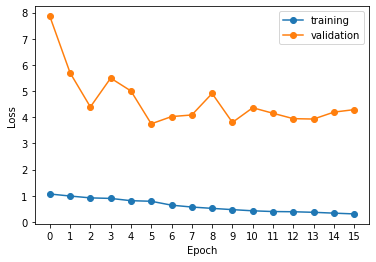

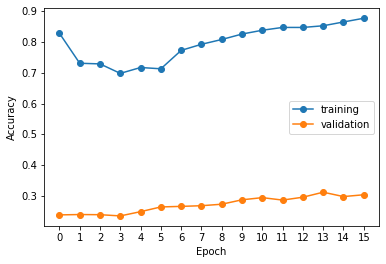

277/277 [==============================] - 2s 6ms/step - loss: 3.6857 - accuracy: 0.3712 - precision: 0.3940 - recall: 0.3319

Test Acc. 37.12%
              precision    recall  f1-score   support

           0       0.32      0.33      0.33      2237
           1       0.41      0.26      0.32      2218
           2       0.41      0.52      0.46      2187
           3       0.35      0.37      0.36      2200

   micro avg       0.37      0.37      0.37      8842
   macro avg       0.37      0.37      0.37      8842
weighted avg       0.37      0.37      0.37      8842
 samples avg       0.37      0.37      0.37      8842

Confusion matrix
[[ 742  307  581  607]
 [ 663  582  489  484]
 [ 357  293 1143  394]
 [ 545  245  595  815]]


In [8]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.2, dropOutRate=0.5,
                     startWithBatchNormalized=True, optimizer="SGD",
                     activation="relu"
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 3
dense_layer[0]; unit:512
dense_layer[1]; unit:512
dense_layer[2]; unit:512
learningRate: 0.01
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 512)               1914368   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
fc_1 (Dense)                 (None, 512)               262656    
_______________________________________

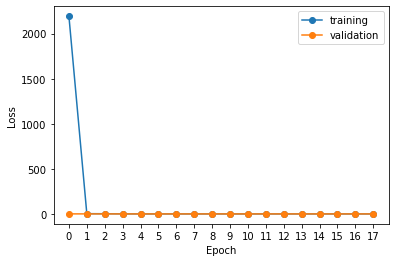

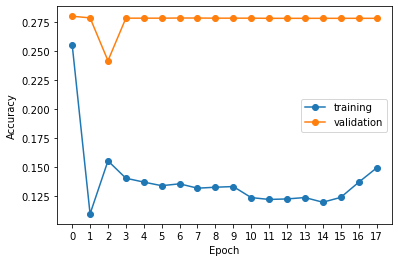

277/277 [==============================] - 2s 6ms/step - loss: 1.3861 - accuracy: 0.2477 - precision: 1.0000 - recall: 2.2619e-04

Test Acc. 24.77%
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      2237
           1       0.00      0.00      0.00      2218
           2       0.25      1.00      0.40      2187
           3       1.00      0.00      0.00      2200

   micro avg       0.25      0.25      0.25      8842
   macro avg       0.56      0.25      0.10      8842
weighted avg       0.56      0.25      0.10      8842
 samples avg       0.25      0.25      0.25      8842

Confusion matrix
[[   1    0 2236    0]
 [   0    0 2218    0]
 [   0    0 2187    0]
 [   0    0 2198    2]]


/home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,512,512], learningRate=0.01, dropOutRate=0.5,
                     startWithBatchNormalized=False, optimizer="Adam",
                     activation="relu"
                    )